<IPython.core.display.Javascript object>


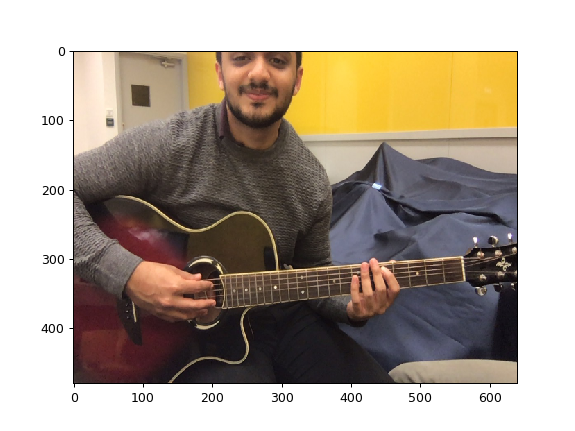

In [13]:
%matplotlib notebook
import cv2
import numpy as np
import imutils
import struct #converts binary strings to integers s
from math import log2, pow
import matplotlib.pyplot as plt
from IPython import display

### WE FIRST RESIZE THE IMAGE TO MAKE IT FASTER TO PROCESS
img = cv2.imread("hamza_serious.jpg")
img = cv2.resize(img, (640, 480))
display_1 = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
height, width, channels = img.shape

plt.imshow(display_1)


<IPython.core.display.Javascript object>


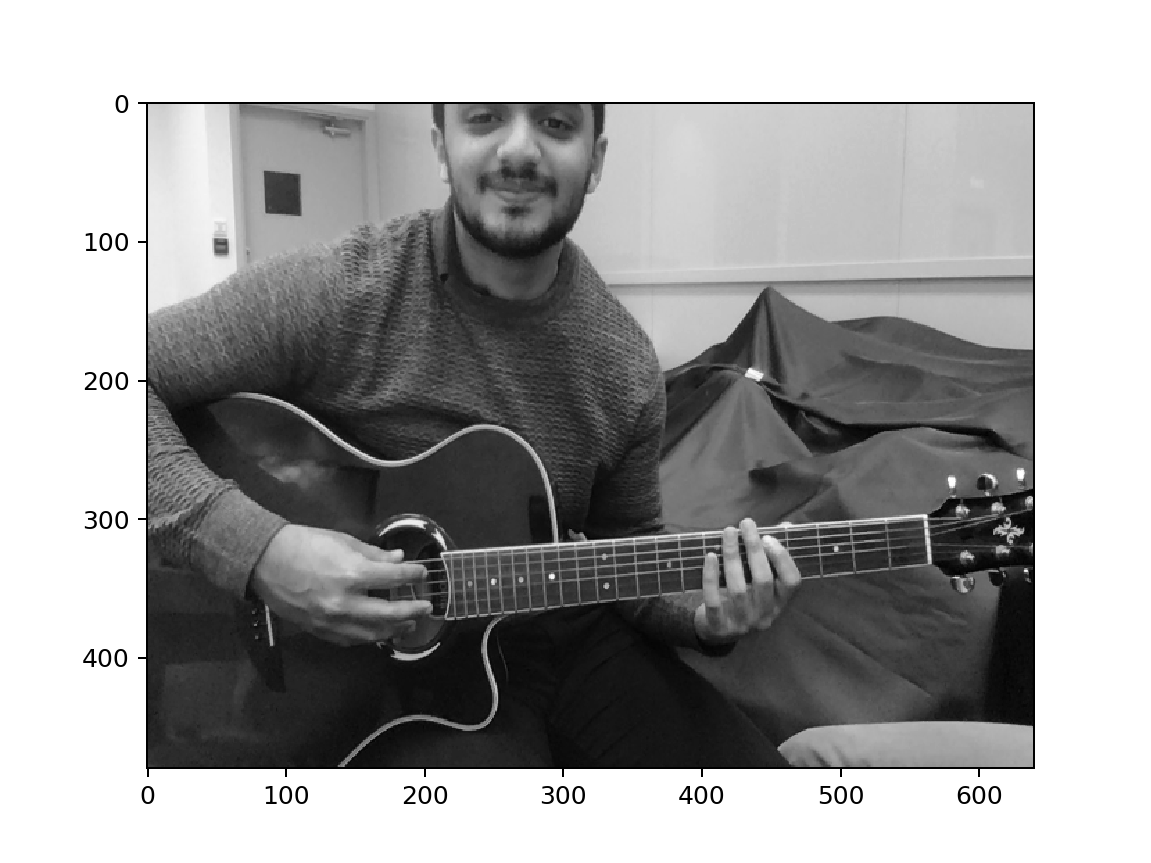

In [2]:
### CONVERT IT TO GRAYSCALE
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.close()
plt.imshow(gray, cmap='gray')

<IPython.core.display.Javascript object>


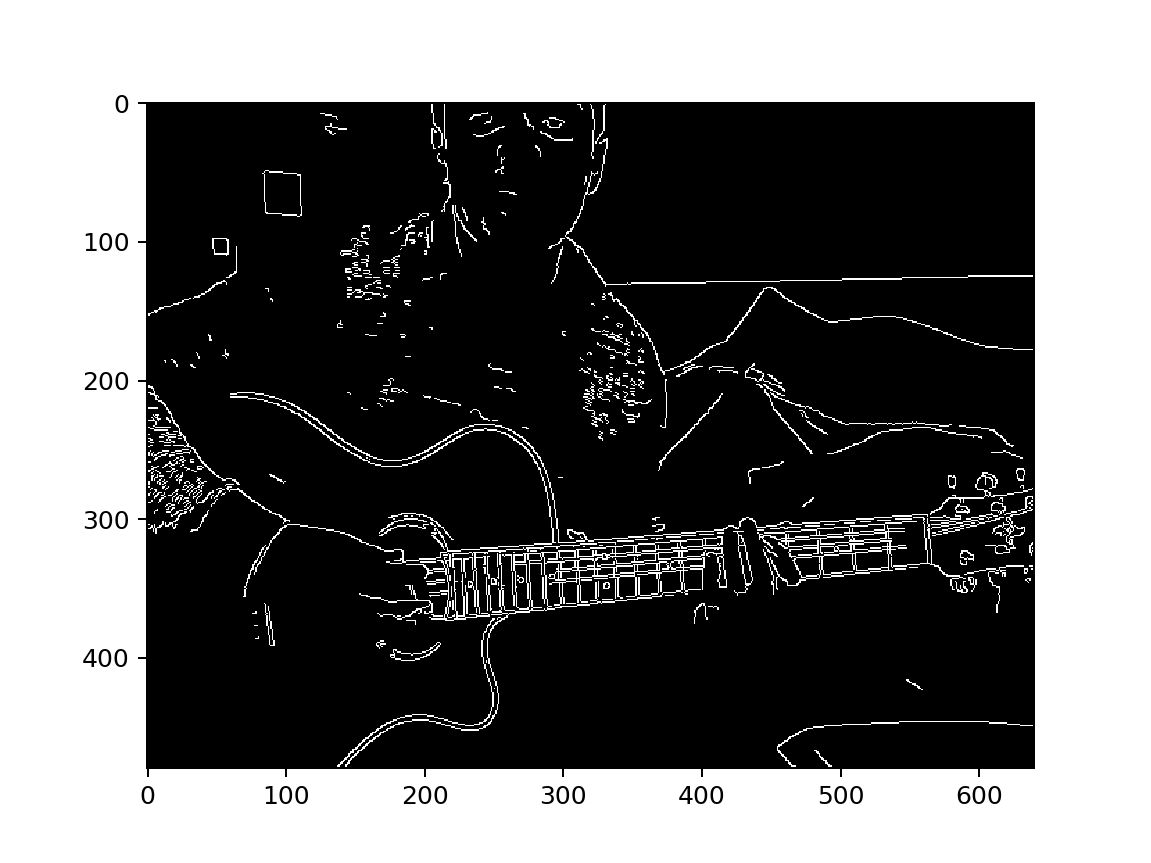

In [3]:
# parameter 1: threshold
edges = cv2.Canny(gray, 150, 250)
plt.close()
plt.imshow(edges, cmap='gray')

<IPython.core.display.Javascript object>


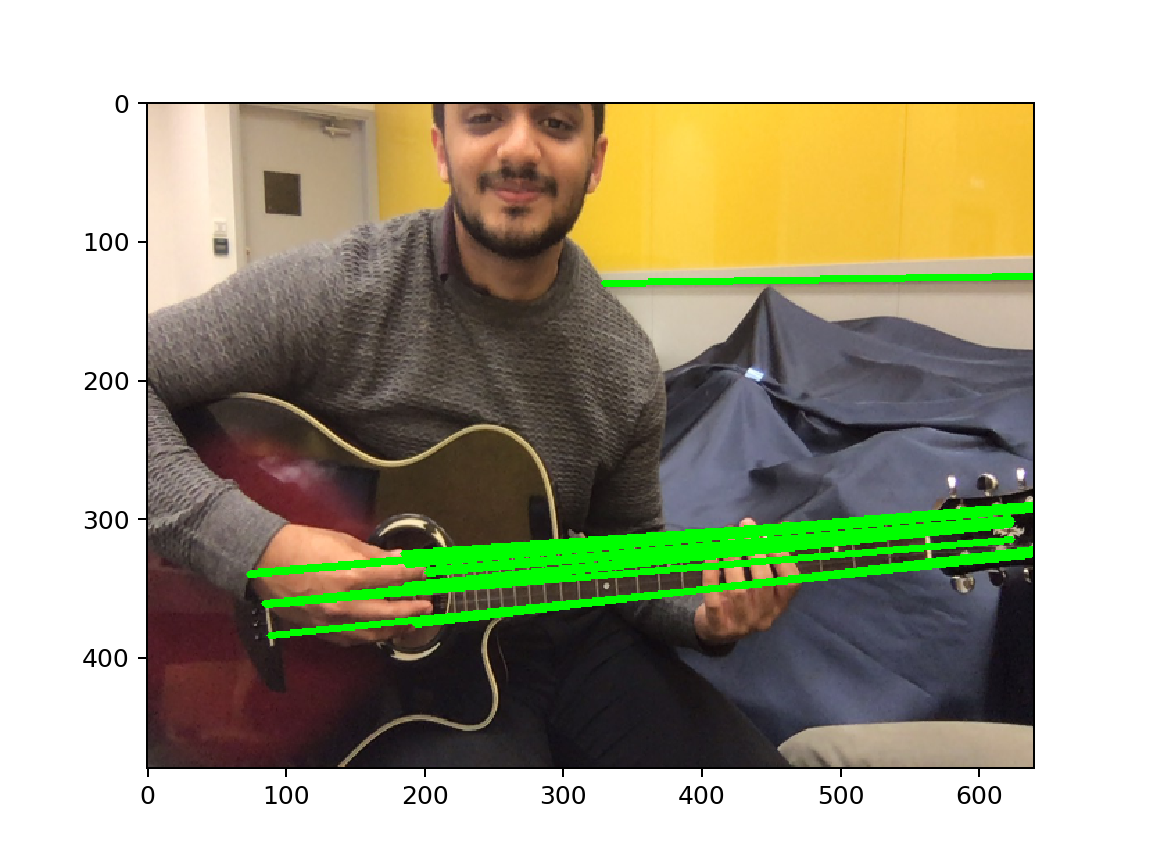

In [4]:
# paramter 2: hough parameters
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 150, maxLineGap=100, minLineLength=300)

hough_1 = img.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(hough_1, (x1, y1), (x2, y2), (0, 255, 0), 3)

display = cv2.cvtColor(hough_1, cv2.COLOR_BGR2RGB)
plt.close()
plt.imshow(display)

<IPython.core.display.Javascript object>


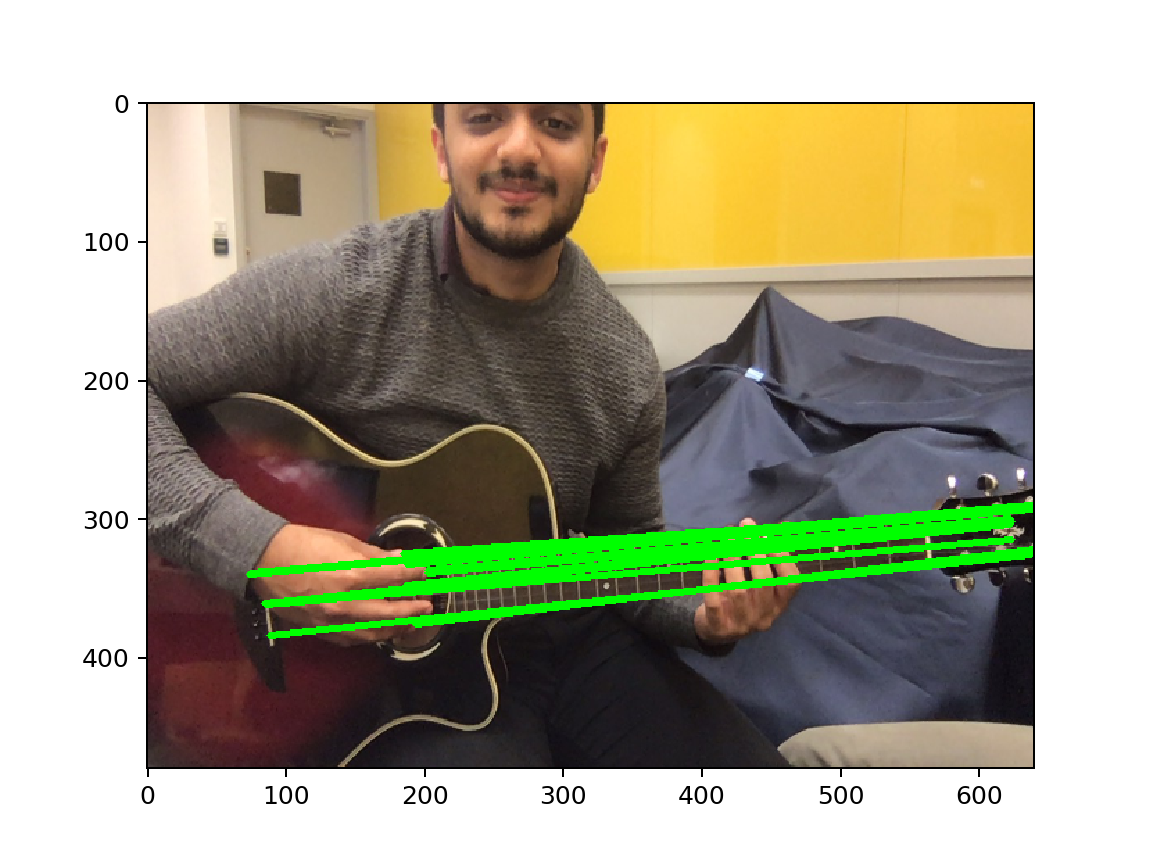

In [5]:
gradients = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    gradients.append((y1 - y2) / (x1 - x2))


median_gradient = np.median(gradients)


lines_filtered = []

# change to angle instead of tan value

# parameter 3: threshold for filtering
for i in range(len(gradients)):
    if (median_gradient < 0):
        if gradients[i] >= (1.5 * median_gradient) and gradients[i] <= (0.5 * median_gradient):
            lines_filtered.append(lines[i])
    else:
        if gradients[i] <= (1.5 * median_gradient) and gradients[i] >= (0.5 * median_gradient):
            lines_filtered.append(lines[i])

after_median_gradient_filter = img.copy()
for line in lines_filtered:
    x1, y1, x2, y2 = line[0]
    cv2.line(after_median_gradient_filter, (x1, y1), (x2, y2), (0, 255, 0), 3)

display = cv2.cvtColor(after_median_gradient_filter, cv2.COLOR_BGR2RGB)
plt.close()
plt.imshow(display)

<IPython.core.display.Javascript object>


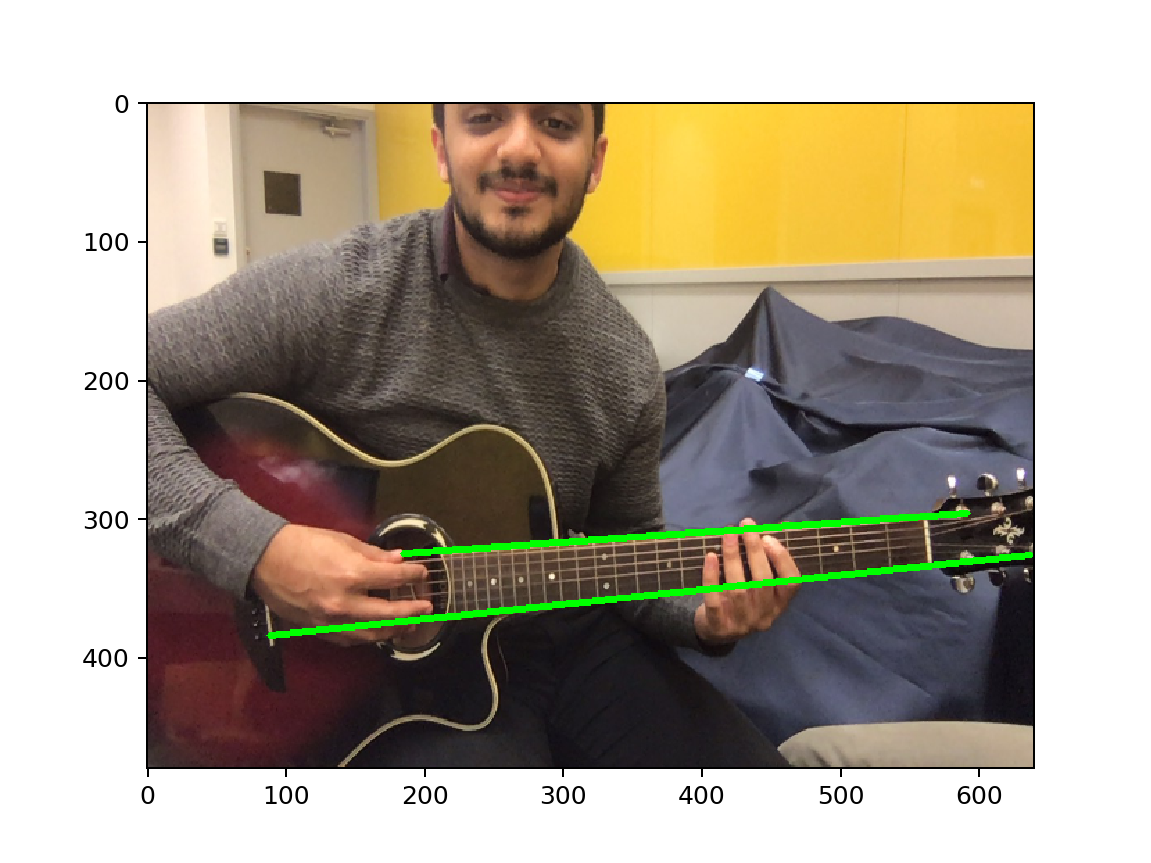

In [6]:
outline = img.copy()
maxyvalues = []
for line in lines_filtered:
    x1, y1, x2, y2 = line[0]
    maxyvalues.append(max(y1, y2))

y_ULimit = -1

y_LLimit = 99999

for line in lines_filtered:
    x1, y1, x2, y2 = line[0]

    max_value = max(y1, y2)
    if max_value > y_ULimit:
        uLine = line
        y_ULimit = max_value

    if max_value < y_LLimit:
        lLine = line
        y_LLimit = max_value

x1, y1, x2, y2 = uLine[0]
cv2.line(outline, (x1, y1), (x2, y2), (0, 255, 0), 3)

x3, y3, x4, y4 = lLine[0]
cv2.line(outline, (x3, y3), (x4, y4), (0, 255, 0), 3)

display = cv2.cvtColor(outline, cv2.COLOR_BGR2RGB)

plt.close()
plt.imshow(display)

<IPython.core.display.Javascript object>


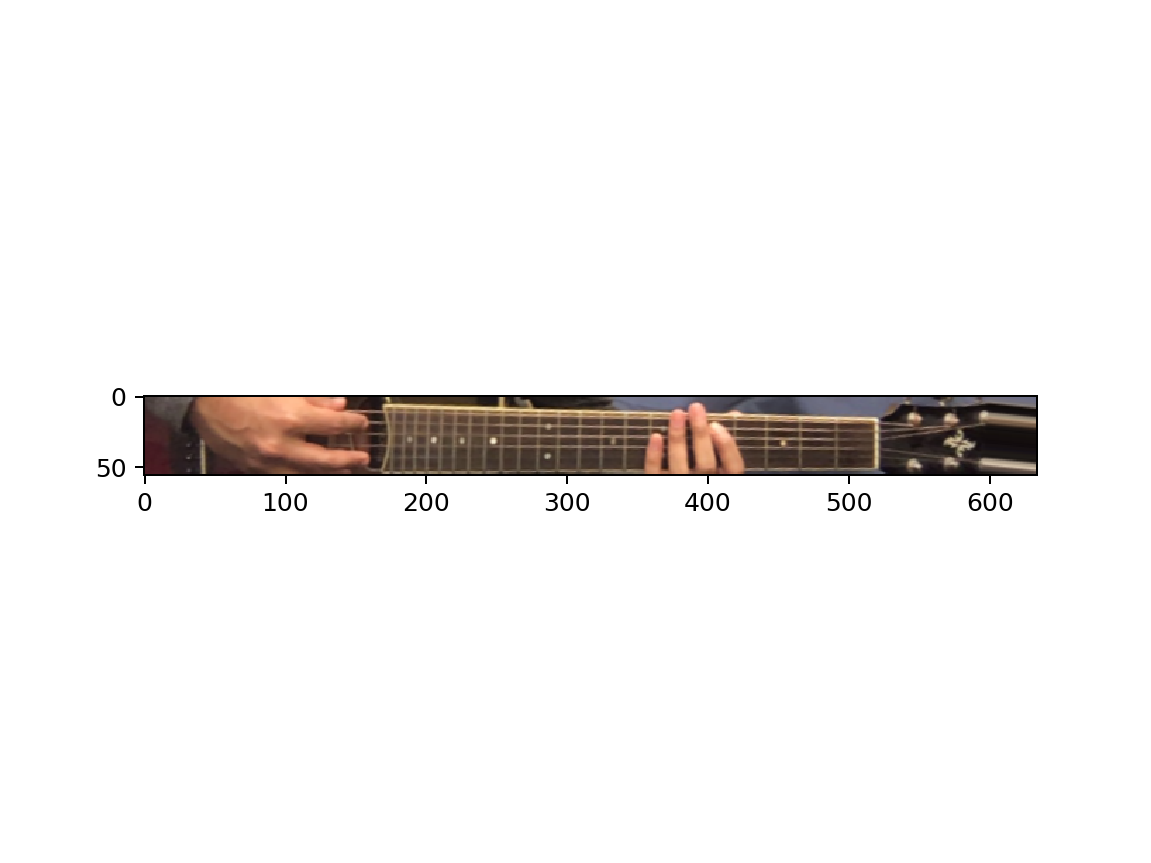

In [7]:
# print shape of mask
mask = np.zeros((height, width), dtype=np.uint8)
points = np.array([[[x1, y1], [x2, y2], [x4, y4], [x3, y3]]])
cv2.fillPoly(mask, points, (255))

_, contours, _ = cv2.findContours(mask, 1, 1)

cnt = contours[0]

rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)

mult = 1.15
img_box = img.copy()
W = rect[1][0]
H = rect[1][1]

Xs = [i[0] for i in box]
Ys = [i[1] for i in box]
x1 = min(Xs)
x2 = max(Xs)
y1 = min(Ys)
y2 = max(Ys)

rotated = False
angle = rect[2]

if angle < -45:
    angle += 90
    rotated = True

center = (int((x1+x2)/2), int((y1+y2)/2))
size = (int(mult*(x2-x1)),int(mult*(y2-y1)))

M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

cropped = cv2.getRectSubPix(img_box, size, center)
cropped = cv2.warpAffine(cropped, M, size)

croppedW = W if not rotated else H
croppedH = H if not rotated else W

croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW*mult), int(croppedH*mult)), (size[0]/2, size[1]/2))

display = cv2.cvtColor(croppedRotated, cv2.COLOR_BGR2RGB)
plt.close()
plt.imshow(display)

<IPython.core.display.Javascript object>


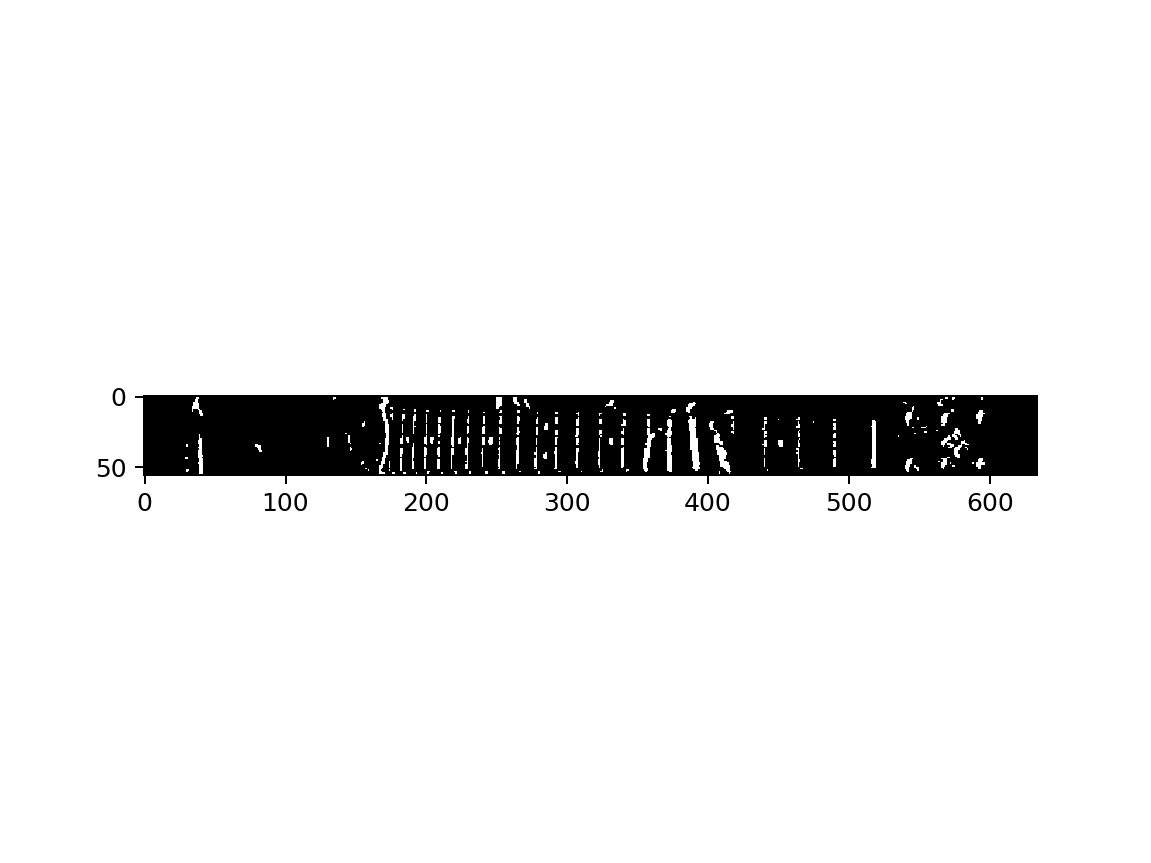

In [8]:
### End of Part 1. To check. Uncomment line above

gray = cv2.cvtColor(croppedRotated.copy(), cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray, -1, 1, 0, ksize=1)
cv2.imshow("Sobelx", sobelx)

ret,thresh1 = cv2.threshold(sobelx,20,255,cv2.THRESH_BINARY)
cv2.imshow("Threshold", thresh1)

kernel = np.ones((5,5),np.uint8)

median = cv2.medianBlur(thresh1, 1)
cv2.imshow("median", median)
# closing = cv2.morphologyEx(median, cv2.MORPH_CLOSE, kernel)
# cv2.imshow("closing", closing)

plt.close()
plt.imshow(median, cmap='gray')

<IPython.core.display.Javascript object>


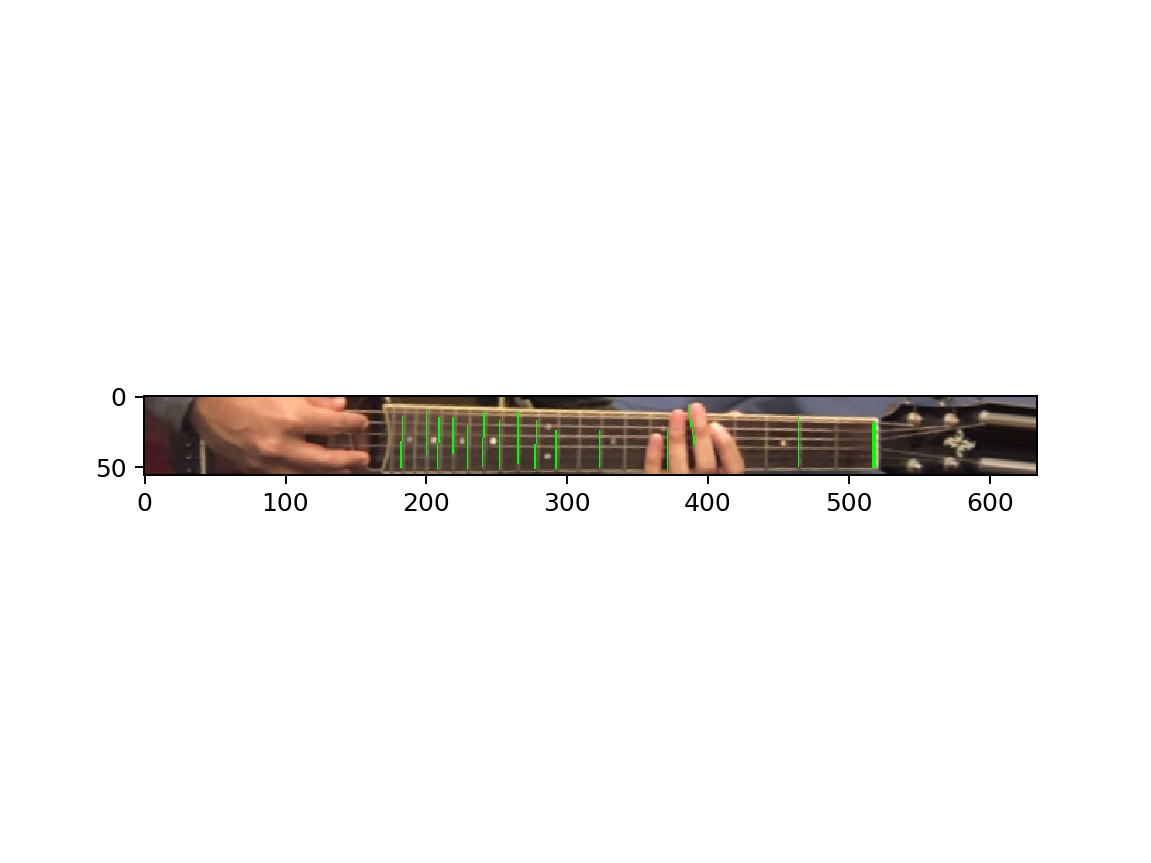

In [9]:
lines = cv2.HoughLinesP(median, 1, np.pi/180, 3, maxLineGap=3, minLineLength=25)

hough_vert = croppedRotated.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(hough_vert, (x1, y1), (x2, y2), (0, 255, 0), 1)

cv2.imshow("Hough Transform (Only Vertical)", hough_vert)

display = cv2.cvtColor(hough_vert, cv2.COLOR_BGR2RGB)
plt.close()
plt.imshow(display)

<IPython.core.display.Javascript object>


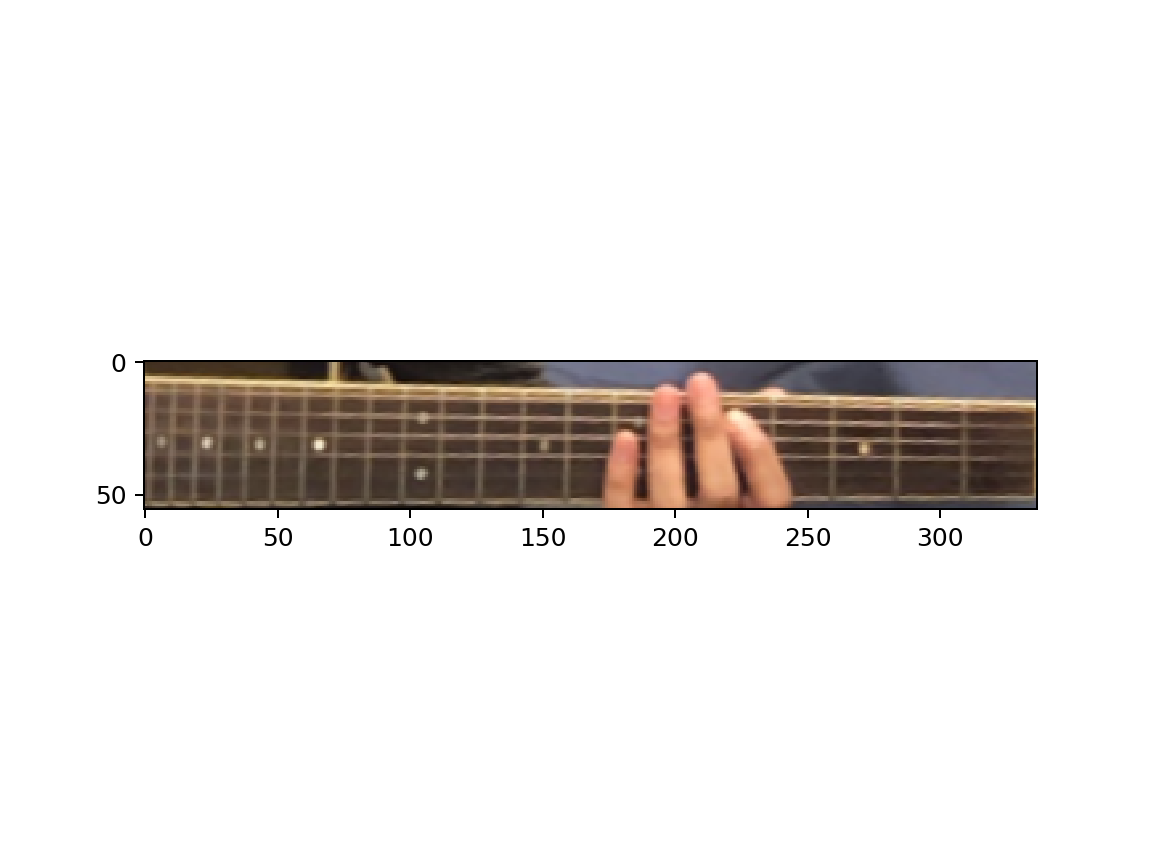

In [10]:
min_x = 99999
max_x = 0
if lines is not None:
    for line in lines:
        x1, _, _, _ = line[0]
        if x1 < min_x:
            min_x = x1
        if x1 > max_x:
            max_x = x1


roi = croppedRotated[0:,min_x:max_x]

display = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
plt.close()
plt.imshow(display)

<IPython.core.display.Javascript object>


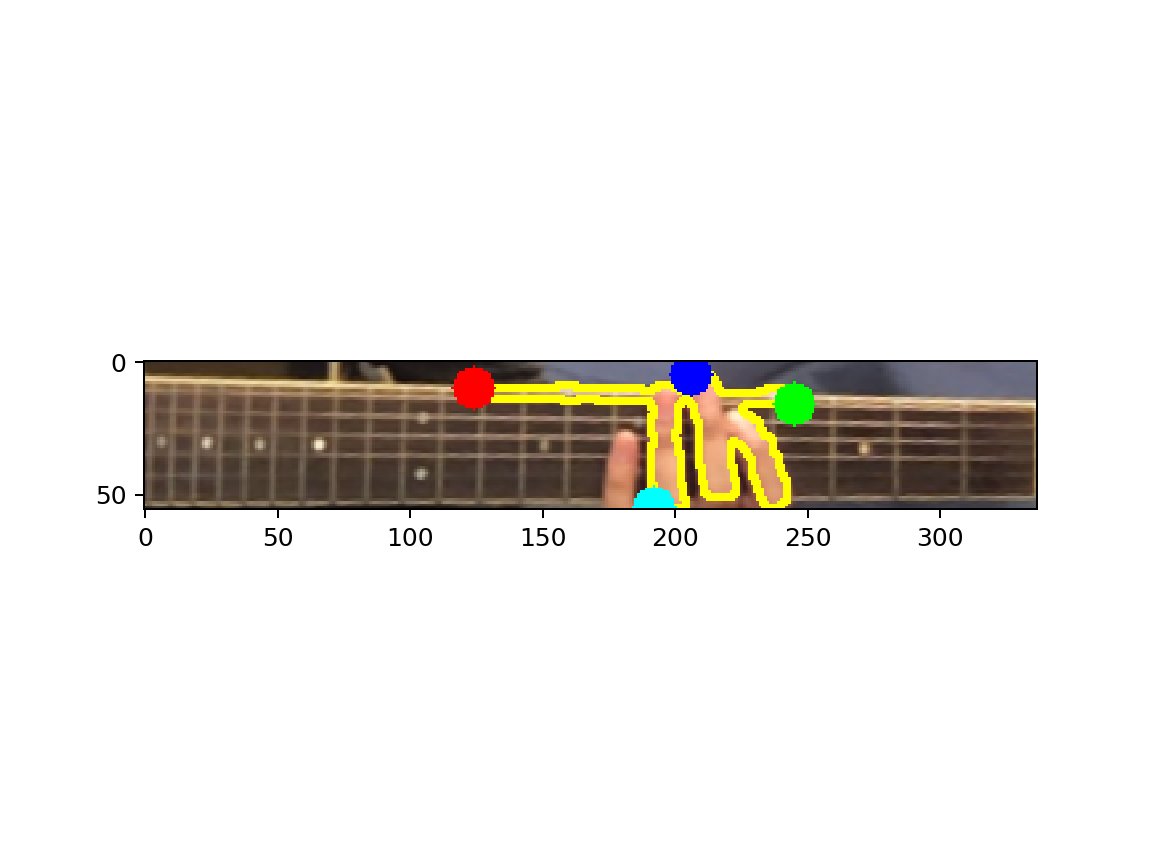

In [11]:
imgray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
#cv2.imshow("GRY", imgray)
imgray = cv2.GaussianBlur(imgray, (5, 5), 0)
# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise

ret, thresh = cv2.threshold(imgray, 127, 255, 0)
# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

#cv2.imshow("DFS",thresh)

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

c = max(cnts, key=cv2.contourArea)
# determine the most extreme points along the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

cv2.drawContours(roi, [c], -1, (0, 255, 255), 2)
cv2.circle(roi, extLeft, 8, (0, 0, 255), -1)
cv2.circle(roi, extRight, 8, (0, 255, 0), -1)
cv2.circle(roi, extTop, 8, (255, 0, 0), -1)
cv2.circle(roi, extBot, 8, (255, 255, 0), -1)

result_from_cv_algo = (1 - (extBot[0]/ roi.shape[1])) * 100

display = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
plt.close()
plt.imshow(display)

In [12]:
def get_fretboard_position(pitch, result_from_cv_algo):
    fret_lengths = [0, 1.431, 2.782, 4.057,
        5.261, 6.397, 7.469, 8.481,
        9.436, 10.338, 11.189, 11.992,
        12.75, 13.466, 14.141, 14.779,
        15.38, 15.948, 16.483, 16.99,
        17.468, 17.919, 18.344]
    fret_lengths_ratios = [0.0, 7.8, 15.17, 22.12, 28.68, 34.87, 40.72, 46.23, 51.44, 56.36, 61.0, 65.37, 69.51, 73.41, 77.09, 80.57, 83.84, 86.94, 89.85, 92.62, 95.22, 97.68, 100.0]
    note_posible_combinations = {
        'E2': [(6, 0)],
        'F2': [(6, 1)],
        'F#2': [(6, 2)],
        'G2': [(6, 3)],
        'G#2': [(6, 4)],
        'A2': [(6, 5), (5, 0)],
        'A#2': [(6, 6), (5, 1)],
        'B2': [(7, 6), (5, 2)],

        'C3': [(6,8), (5,3)],
        'C#3': [(6,9), (5,4)],
        'D3': [(6,10), (5,5), (4,0)],
        'D#3': [(6,11), (5,6), (4,1)],
        'E3': [(6,12), (5,7), (4,2)],
        'F3': [(6,13), (5,8), (4,3)],
        'F#3': [(6,14), (5,9), (4,4)],
        'G3': [(6,15), (5,10), (4,5), (3,0)],
        'G#3': [(6,16), (5,11), (4,6), (3,1)],
        'A3': [(6,17), (5,12), (4,7), (3,2)],
        'A#3': [(6,18), (5,13), (4,8), (3,3)],
        'B3': [(6,19), (5,14), (4,9), (3,4), (2,0)],

        'C4': [(6,20), (5,15), (4,10), (3,5), (2,1)],
        'C#4': [(6,21), (5,16), (4,11), (3,6), (2,2)],
        'D4': [(6,22), (5,17), (4,12), (3,7), (2,3)],
        'D#4': [(5,18), (4,13), (3,8), (2,4)],
        'E4': [(5,19), (4,14), (3,9), (2,5), (1,0)],
        'F4': [(5,20), (4,15), (3,10), (2,6), (1,1)],
        'F#4': [(5,21), (4,16), (3,11), (2,7), (1,2)],
        'G4': [(5,22), (4,17), (3,12), (2,8), (1,3)],
        'G#4': [(4,18), (3,13), (2,9), (1,4)],
        'A4': [(4,19), (3,14), (2,10), (1,5)],
        'A#4': [(4,20), (3,15), (2,11), (1,6)],
        'B4': [(4,21), (3,16), (2,12), (1,7)],


        'C5': [(4,22), (3,17), (2,13), (1,8)],
        'C#5': [(3,18), (2,14), (1,9)],
        'D5': [(3,19), (2,15), (1,10)],
        'D#5': [(3,20), (2,16), (1,11)],
        'E5': [(3,21), (2,17), (1,12)],
        'F5': [(3,22), (2,18), (1,13)],
        'F#5': [(2,19), (1,14)],
        'G5': [(2,20), (1,15)],
        'G#5': [(2,21), (1,16)],
        'A5': [(2,22), (1,17)],
        'A#5': [(1,18)],
        'B5': [(1,19)],

        'C6': [(1,20)],
        'C#6': [(1,21)],
        'D6': [(1,22)]
    }

    differences = []
    for (_, y) in note_posible_combinations[pitch]:
        differences.append(abs(result_from_cv_algo - fret_lengths_ratios[y]))

    index = np.argmin(np.array(differences))
    return note_posible_combinations['D3'][index]


print("Result from CV Algorithm: ", result_from_cv_algo)
print("Result of Pitch Detection: D3")

(string, fret) = get_fretboard_position('D3', result_from_cv_algo)
print("String ", string,": Fret ", fret)

Result from CV Algorithm:  43.02670623145401
Result of Pitch Detection: D3
String  5 : Fret  5
